# Erastar data in zarr

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import pyproj
from rasterio.transform import Affine

import matplotlib.pyplot as plt
import matplotlib.colors as cl

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo

crs = ccrs.PlateCarree()
import cmocean.cm as cm

from xgcm import Grid
from xhistogram.xarray import histogram
import warnings

warnings.filterwarnings("ignore")

import os
from glob import glob

import histlib.box as box
import histlib.aviso as aviso
import histlib.cstes as cstes

# import histlib.diagnosis as diag
import histlib.erastar as eras

from dask.distributed import wait
from histlib.cstes import labels, zarr_dir

/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


## Time's estimation 

11 load t =< 2min 
1 obs load pour 25 t =< 1/5 min environ  -> temps = 1/5 *taillechunkobs * nbchunk/nbprocess = 1/4 * totalobs/nbcores  
taillechunkobs = nb_obs/nb_cores/n n entier naturel

In [2]:
if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    from dask import config

    config.set({"distributed.comm.timeouts.connect": "200s"})
    cluster = PBSCluster(cores=10, processes=10, walltime="04:00:00")
    # cluster = PBSCluster(cores=20, processes=20, walltime='02:00:00')#8
    w = cluster.scale(jobs=1)
else:
    from dask.distributed import Client, LocalCluster

    cluster = LocalCluster()

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.218:8787/status,
Dashboard: http://10.148.0.218:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.218:49584,Workers: 0
Dashboard: http://10.148.0.218:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
i = 0
dt = (-12, 13)  # 12h before, 12h after
l = "gps_Jason-2_2009"  # labels[i]

ds_data = xr.open_zarr(cstes.zarr_dir + "/" + l + ".zarr")
ds_data = (
    ds_data.where(ds_data.alti___distance < 2e5, drop=True)
    .chunk({"obs": 500, "alti_time": -1, "site_obs": -1})
    .persist()
)  # 73334

In [4]:
ds_es = eras.compute_eras(
    ds_data.isel(obs=slice(0, 10)).chunk({"obs": 5, "alti_time": -1, "site_obs": -1}),
    dt=(-12, 13),
    only_matchup_time=True,
).persist()
ds_es

[] 2009/001/2009010111*.nc


AssertionError: (array(['2022710', '2023710'], dtype=object), array([0, 1]))

## Test
i=4:
job=3, cores=15, processes=15, chunks=20, dt=25 all -> error at first concat_eras
job=2, cores=15, processes=15, chunks=25, dt=25, slice(500,2000) -> error with some concat_eras_ (66 errors)  
job=2, cores=15, processes=15, chunks=25, dt=25, slice(1500,3000) -> error with some concat_eras_ (88 errors)
job=1, cores=10, processes=10, chunks=25, dt=13, slice(500,2000) -> error with some concat_eras_ (66 errors) on the same worker

correct limite_lon

i=4 job=3, cores=15, processes=15, chunks=34, dt=25 all -> ok
i=2 job=8, cores=20, processes = 20,, chunks=50,dt=25 all -> pb memory

0,10000 ; 10000,30000 ; 30000, 55000 ; 55000,74235 ;

In [3]:
i = 0
dt = (-12, 13)  # 12h before, 12h after
l = labels[i]

ds_data = xr.open_zarr(cstes.zarr_dir + "/" + l + ".zarr")
ds_data = (
    ds_data.where(ds_data.alti___distance < 2e5, drop=True)
    .chunk({"obs": 500, "alti_time": -1, "site_obs": -1})
    .persist()
)  # 73334
ds_data.to_zarr(os.path.join(zarr_dir, "test", f"{l}.zarr"))

In [5]:
ds_data

<xarray.Dataset>
Dimensions:                                       (obs: 405, alti_time: 211,
                                                   alti_time_mid: 210,
                                                   box_y: 80, box_x: 120,
                                                   site_obs: 1489)
Coordinates: (12/20)
    alti_lat                                      (obs, alti_time) float64 dask.array<chunksize=(405, 211), meta=np.ndarray>
    alti_lon                                      (obs, alti_time) float64 dask.array<chunksize=(405, 211), meta=np.ndarray>
  * alti_time                                     (alti_time) int64 0 1 ... 210
    alti_time_                                    (obs, alti_time) datetime64[ns] dask.array<chunksize=(405, 211), meta=np.ndarray>
  * alti_time_mid                                 (alti_time_mid) float64 0.5...
    alti_x                                        (obs, alti_time) float64 dask.array<chunksize=(405, 211), meta=np.ndarray>
    ...                                            ...
    drifter_x                                     (obs, site_obs) float64 dask.array<chunksize=(405, 1489), meta=np.ndarray>
    drifter_y                                     (obs, site_obs) float64 dask.array<chunksize=(405, 1489), meta=np.ndarray>
    lat                                           (obs) float64 dask.array<chunksize=(405,), meta=np.ndarray>
    lon                                           (obs) float64 dask.array<chunksize=(405,), meta=np.ndarray>
  * obs                                           (obs) int64 0 1 2 ... 439 440
    time                                          (obs) datetime64[ns] dask.array<chunksize=(405,), meta=np.ndarray>
Dimensions without coordinates: site_obs
Data variables: (12/68)
    __site_id                                     (obs) object dask.array<chunksize=(405,), meta=np.ndarray>
    __site_matchup_indice                         (obs) float64 dask.array<chunksize=(405,), meta=np.ndarray>
    __site_name                                   (obs) object dask.array<chunksize=(405,), meta=np.ndarray>
    alti___distance                               (obs) float64 dask.array<chunksize=(405,), meta=np.ndarray>
    alti___source                                 (obs) object dask.array<chunksize=(405,), meta=np.ndarray>
    alti___source_center_index                    (obs) object dask.array<chunksize=(405,), meta=np.ndarray>
    ...                                            ...
    drifter_typedeath                             (obs, site_obs) float64 dask.array<chunksize=(405, 1489), meta=np.ndarray>
    drifter_ve                                    (obs, site_obs) float32 dask.array<chunksize=(405, 1489), meta=np.ndarray>
    drifter_vn                                    (obs, site_obs) float32 dask.array<chunksize=(405, 1489), meta=np.ndarray>
    drifter_vx                                    (obs, site_obs) float64 dask.array<chunksize=(405, 1489), meta=np.ndarray>
    drifter_vy                                    (obs, site_obs) float64 dask.array<chunksize=(405, 1489), meta=np.ndarray>
    f                                             (obs) float64 dask.array<chunksize=(405,), meta=np.ndarray>
Attributes:
    __id:                   CMEMS-L3-SLA-Jason-2__gps
    __time_coverage_end:    2009-10-01T00:00:00
    __time_coverage_start:  2009-01-01T00:00:00

In [10]:
ds_es = eras.compute_eras(
    ds_data.chunk({"obs": 5, "alti_time": -1, "site_obs": -1}),
    dt=(-12, 13),
    only_matchup_time=True,
).persist()
zarr = os.path.join(zarr_dir, "test", "erastar_" + l + ".zarr")
ds_es.chunk({"obs": 500}).to_zarr(zarr, mode="w")
print(f"erastar {l} storred in {zarr}")

erastar gps_Jason-3_2020 storred in /home/datawork-lops-osi/aponte/margot/historical_coloc/test/erastar_gps_Jason-3_2020.zarr


In [7]:
zarr = os.path.join(zarr_dir, "erastar/erastar_" + l + ".zarr")
ds_es.chunk({"obs": 500}).to_zarr(zarr, mode="w")
print(f"erastar {l} storred in {zarr}")

erastar argos_SASSA_Sentinel_2016 storred in /home1/datawork/mdemol/m2/erastar/erastar_argos_SASSA_Sentinel_2016.zarr


In [5]:
ds_es

<xarray.Dataset>
Dimensions:                  (box_x: 80, box_y: 40, obs: 4054, site_obs: 1489,
                              es_time: 25)
Coordinates:
  * box_x                    (box_x) float64 -2e+05 -1.95e+05 ... 1.95e+05
  * box_y                    (box_y) float64 -1e+05 -9.5e+04 ... 9e+04 9.5e+04
    es_time_                 (obs, es_time) datetime64[ns] dask.array<chunksize=(25, 25), meta=np.ndarray>
    time                     (obs) datetime64[ns] dask.array<chunksize=(25,), meta=np.ndarray>
Dimensions without coordinates: obs, site_obs, es_time
Data variables: (12/23)
    es_traj_taue             (obs, site_obs) float64 dask.array<chunksize=(25, 1489), meta=np.ndarray>
    es_traj_taun             (obs, site_obs) float64 dask.array<chunksize=(25, 1489), meta=np.ndarray>
    e5_traj_taue             (obs, site_obs) float64 dask.array<chunksize=(25, 1489), meta=np.ndarray>
    e5_traj_taun             (obs, site_obs) float64 dask.array<chunksize=(25, 1489), meta=np.ndarray>
    drifter_time             (obs, site_obs) datetime64[ns] dask.array<chunksize=(25, 1489), meta=np.ndarray>
    drifter_x                (obs, site_obs) float64 dask.array<chunksize=(25, 1489), meta=np.ndarray>
    ...                       ...
    e5_drifter_temp_taue     (obs, es_time) float64 dask.array<chunksize=(25, 25), meta=np.ndarray>
    e5_drifter_temp_taun     (obs, es_time) float64 dask.array<chunksize=(25, 25), meta=np.ndarray>
    es_alti_matchup_taue     (obs) float64 dask.array<chunksize=(25,), meta=np.ndarray>
    es_alti_matchup_taun     (obs) float64 dask.array<chunksize=(25,), meta=np.ndarray>
    e5_alti_matchup_taue     (obs) float64 dask.array<chunksize=(25,), meta=np.ndarray>
    e5_alti_matchup_taun     (obs) float64 dask.array<chunksize=(25,), meta=np.ndarray>
Attributes: (12/55)
    Conventions:                 CF-1.7, ACDD-1.3, ISO 8601
    Metadata_Conventions:        Climate and Forecast (CF) 1.7, Attribute Con...
    standard_name_vocabulary:    NetCDF Climate and Forecast (CF) Metadata Co...
    title:                       hourly stress equivalent model wind componen...
    summary:                     This data set contains the stress equivalent...
    id:                          WOC-L4-SE-ERAstar-H
    ...                          ...
    platform:                    Metop-A, Metop-B
    platform_type:               low earth orbit satellite, low earth orbit s...
    instrument:                  ASCAT, ASCAT
    instrument_type:             scatterometer, scatterometer
    band:                        C, C
    format_version:              WOС v1.0

zarr = os.path.join(zarr_dir, "erastar_"+l+".zarr")
ds_es.chunk({'obs':500}).to_zarr(zarr, mode="a", append_dim='obs')  
print(f"erastar {l} storred in {zarr}")

In [4]:
try:
    i = 0
    dt = (-12, 13)  # 12h before, 12h after
    l = labels[i]

    ds_data = xr.open_zarr(cstes.zarr_dir + "/" + l + ".zarr")
    ds_data = ds_data.chunk({"obs": 30, "alti_time": -1, "site_obs": -1}).persist()
    wait(ds_data)

    ds_es = eras.compute_eras(ds_data, dt=(-12, 13), only_matchup_time=True).persist()
    wait(ds_eras)

    zarr = os.path.join(zarr_dir, "erastar_" + l + ".zarr")
    ds_es.chunk({"obs": 500}).to_zarr(zarr, mode="w")
    print(f"erastar {l} storred in {zarr}")
except:
    cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 50.00 seconds, closing client


## Open Test

In [5]:
l = labels[0]
ds_data = xr.open_zarr(
    "/home/datawork-lops-osi/aponte/margot/hist_coloc_old/erastar_" + l + ".zarr"
)

In [7]:
i = 0
l = labels[i]
ds_eras_test = xr.open_zarr(cstes.zarr_dir + "/erastar_" + l + "_0.zarr")

In [8]:
ds_eras_test

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*

In [6]:
ds_eras_test

<xarray.Dataset>
Dimensions:                  (box_x: 80, box_y: 40, obs: 4054, site_obs: 1489,
                              es_time: 25)
Coordinates:
  * box_x                    (box_x) float64 -2e+05 -1.95e+05 ... 1.95e+05
  * box_y                    (box_y) float64 -1e+05 -9.5e+04 ... 9e+04 9.5e+04
    es_time_                 (obs, es_time) datetime64[ns] dask.array<chunksize=(2027, 13), meta=np.ndarray>
    time                     (obs) datetime64[ns] dask.array<chunksize=(4054,), meta=np.ndarray>
Dimensions without coordinates: obs, site_obs, es_time
Data variables: (12/19)
    drifter_time             (obs, site_obs) datetime64[ns] dask.array<chunksize=(507, 187), meta=np.ndarray>
    drifter_x                (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    drifter_y                (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    e5_alti_matchup_tauu     (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    e5_alti_matchup_tauv     (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    e5_box_matchup_tauu      (obs, box_y, box_x) float64 dask.array<chunksize=(500, 40, 80), meta=np.ndarray>
    ...                       ...
    es_box_matchup_tauu      (obs, box_y, box_x) float64 dask.array<chunksize=(500, 40, 80), meta=np.ndarray>
    es_box_matchup_tauv      (obs, box_y, box_x) float64 dask.array<chunksize=(500, 40, 80), meta=np.ndarray>
    es_drifter_matchup_tauu  (obs, es_time) float64 dask.array<chunksize=(500, 25), meta=np.ndarray>
    es_drifter_matchup_tauv  (obs, es_time) float64 dask.array<chunksize=(500, 25), meta=np.ndarray>
    es_traj_tauu             (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    es_traj_tauv             (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
Attributes: (12/55)
    Conventions:                 CF-1.7, ACDD-1.3, ISO 8601
    Metadata_Conventions:        Climate and Forecast (CF) 1.7, Attribute Con...
    acknowledgement:             Please acknowledge the use of these data wit...
    band:                        C, C
    cdm_data_type:               grid
    comment:                     These data were produced at ICM/CSIC as part...
    ...                          ...
    summary:                     This data set contains the stress equivalent...
    technical_support_contact:   cersat@ifremer.fr
    time_coverage_end:           20161130T16:00:00
    time_coverage_start:         20161130T16:00:00
    title:                       hourly stress equivalent model wind componen...
    track_id:                    2f84d489-de4c-46a8-85b4-fe55a58c4506

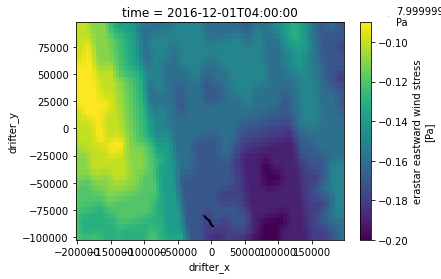

In [8]:
ds_eras_test.isel(obs=3).es_box_matchup_tauu.plot(x="box_x", y="box_y")
ds_eras_test.isel(obs=3).plot.quiver(
    x="drifter_x", y="drifter_y", u="es_traj_tauu", v="es_traj_tauv"
)

In [30]:
_ds = ds_eras_test.isel(obs=10).dropna("site_obs", how="any").compute()
_ds

<xarray.Dataset>
Dimensions:                  (box_y: 40, box_x: 80, es_time: 25, site_obs: 25)
Coordinates:
  * box_x                    (box_x) float64 -2e+05 -1.95e+05 ... 1.95e+05
  * box_y                    (box_y) float64 -1e+05 -9.5e+04 ... 9e+04 9.5e+04
    es_time_                 (es_time) datetime64[ns] 2016-12-01 ... 2016-12-02
    time                     datetime64[ns] 2016-12-01T12:00:00
Dimensions without coordinates: es_time, site_obs
Data variables: (12/19)
    alti_matchup_e5_tauu     float64 -0.02583
    alti_matchup_e5_tauv     float64 0.2875
    alti_matchup_es_tauu     float64 -0.03759
    alti_matchup_es_tauv     float64 0.2919
    box_matchup_e5_tauu      (box_y, box_x) float64 -0.1266 -0.13 ... -0.01517
    box_matchup_e5_tauv      (box_y, box_x) float64 0.2025 0.2 ... 0.3054 0.3084
    ...                       ...
    drifter_x                (site_obs) float64 4.65e+03 4.41e+03 ... -1.237e+04
    drifter_y                (site_obs) float64 -2.092e+04 ... -1.511e+04
    traj_e5_tauu             (site_obs) float64 -0.004314 -0.00419 ... 0.16
    traj_e5_tauv             (site_obs) float64 0.04 0.05 0.06 ... 0.1174 0.08
    traj_es_tauu             (site_obs) float64 -0.01 -0.01 ... 0.1532 0.1367
    traj_es_tauv             (site_obs) float64 0.03947 0.04962 ... 0.07667
Attributes: (12/55)
    Conventions:                 CF-1.7, ACDD-1.3, ISO 8601
    Metadata_Conventions:        Climate and Forecast (CF) 1.7, Attribute Con...
    acknowledgement:             Please acknowledge the use of these data wit...
    band:                        C, C
    cdm_data_type:               grid
    comment:                     These data were produced at ICM/CSIC as part...
    ...                          ...
    summary:                     This data set contains the stress equivalent...
    technical_support_contact:   cersat@ifremer.fr
    time_coverage_end:           20161130T16:00:00
    time_coverage_start:         20161130T16:00:00
    title:                       hourly stress equivalent model wind componen...
    track_id:                    2f84d489-de4c-46a8-85b4-fe55a58c4506

In [15]:
ds_eras_test.isel(obs=10).e5_traj_tauu.compute()

<xarray.DataArray 'e5_traj_tauu' (site_obs: 1489)>
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
    time     datetime64[ns] 2018-01-02T08:00:00
Dimensions without coordinates: site_obs
Attributes:
    long_name:      era5 eastward wind stress
    standard_name:  surface_downward_eastward_stress
    units:          Pa

In [5]:
cluster.close()